In [23]:
%pip -q install matplotlib pandas

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.3 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [6]:
from pyspark.sql import SparkSession

# Créer une session Spark en mode local
spark = SparkSession.builder \
    .appName("ctr_prediction") \
    .config("spark.hadoop.fs.defaultFS", "hdfs://OUARAS:9000") \
    .config("spark.driver.memory", "4g") \
    .config("spark.executor.memory", "4g") \
    .config("spark.driver.maxResultSize", "2g") \
    .config("spark.executor.cores", "2") \
    .config("spark.executor.instances", "2") \
    .config("spark.sql.execution.arrow.pyspark.enabled", "true") \
    .master("local[8]") \
    .getOrCreate()

print("Spark Session démarrée")

Spark Session démarrée


In [7]:
spark

In [8]:
spark.conf.set("spark.sql.pivotMaxValues", 50000)

In [9]:
sc = spark.sparkContext

## Data Organization (HDFS : HADOOP FILE SYSTEM)

### HDFS Path

In [10]:
hdfs_path = "hdfs://OUARAS:9000/ctr_prediction/"
Data_path = f"{hdfs_path}Data/"
Models_path = f"{hdfs_path}Models/"
Output_path = f"{hdfs_path}Output/"

In [11]:
# Lecture des trois fichiers depuis HDFS
train_path = f"{Data_path}ctr_train.csv"
test_path = f"{Data_path}ctr_test.csv"
submission_path = f"{Data_path}ctr_sample_submission.csv"

In [14]:
# Lecture avec inférence de schéma
df_train = spark.read.csv(train_path, header=True, inferSchema=True)

# Vérification rapide
print("=== TRAIN ===")
df_train.show(5)
df_train.printSchema()

=== TRAIN ===
+---+--------------------+-----+--------+----+----------+--------+-----------+-------------+--------+----------+------------+---------+---------+------------+-----------+----------------+-----+---+---+----+---+---+------+---+
|idx|                  id|click|    hour|  C1|banner_pos| site_id|site_domain|site_category|  app_id|app_domain|app_category|device_id|device_ip|device_model|device_type|device_conn_type|  C14|C15|C16| C17|C18|C19|   C20|C21|
+---+--------------------+-----+--------+----+----------+--------+-----------+-------------+--------+----------+------------+---------+---------+------------+-----------+----------------+-----+---+---+----+---+---+------+---+
|  1| 1000009418151094273|    0|14102100|1005|         0|1fbe01fe|   f3845767|     28905ebd|ecad2386|  7801e8d9|    07d7df22| a99f214a| ddd2926e|    44956a24|          1|               2|15706|320| 50|1722|  0| 35|    -1| 79|
|  2|10000169349117863715|    0|14102100|1005|         0|1fbe01fe|   f3845767|    

In [12]:
# Lecture avec inférence de schéma
df_test = spark.read.csv(test_path, header=True, inferSchema=True)

# Vérification rapide
print("=== TEST ===")
df_test.show(5)

=== TEST ===
+---+--------------------+--------+----+----------+--------+-----------+-------------+--------+----------+------------+---------+---------+------------+-----------+----------------+-----+---+---+----+---+---+------+---+
|idx|                  id|    hour|  C1|banner_pos| site_id|site_domain|site_category|  app_id|app_domain|app_category|device_id|device_ip|device_model|device_type|device_conn_type|  C14|C15|C16| C17|C18|C19|   C20|C21|
+---+--------------------+--------+----+----------+--------+-----------+-------------+--------+----------+------------+---------+---------+------------+-----------+----------------+-----+---+---+----+---+---+------+---+
|  4|10000640724480838376|14102100|1005|         0|1fbe01fe|   f3845767|     28905ebd|ecad2386|  7801e8d9|    07d7df22| a99f214a| e8275b8f|    6332421a|          1|               0|15706|320| 50|1722|  0| 35|100084| 79|
|  6|10000720757801103869|14102100|1005|         0|d6137915|   bb1ef334|     f028772b|ecad2386|  7801e8d9| 

In [13]:
# Lecture avec inférence de schéma
df_submission = spark.read.csv(submission_path, header=True, inferSchema=True)

# Vérification rapide
print("=== SUBMISSION ===")
df_submission.show(5)

=== SUBMISSION ===
+---+-----+
|idx|click|
+---+-----+
|  4| NULL|
|  6| NULL|
| 13| NULL|
| 17| NULL|
| 20| NULL|
+---+-----+
only showing top 5 rows



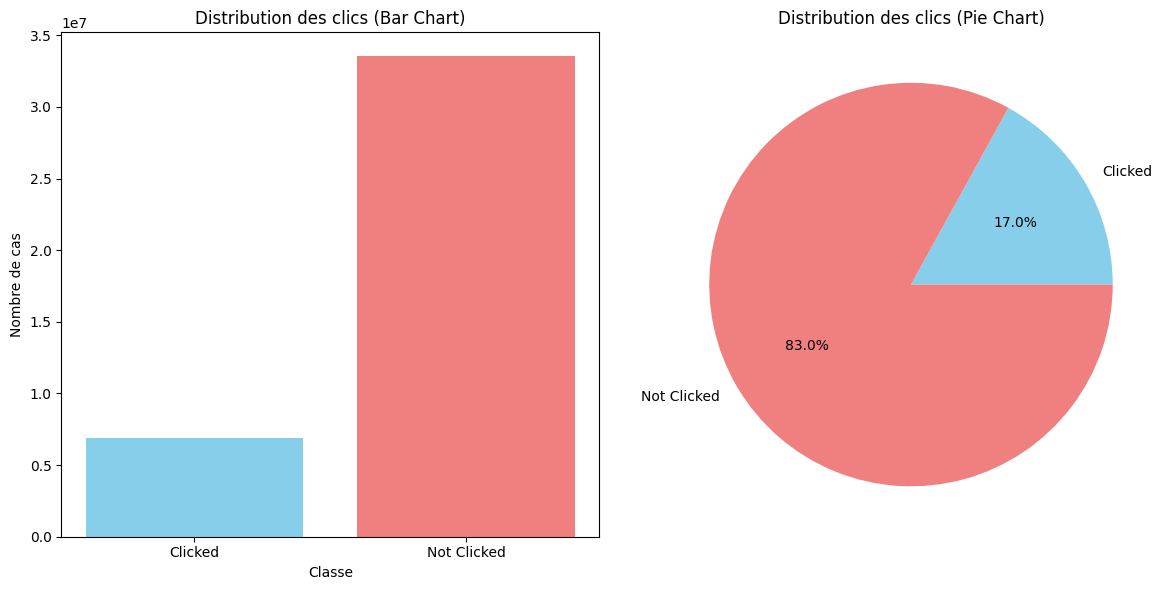

In [17]:
from pyspark.sql.functions import when, col
import matplotlib.pyplot as plt

# Ajouter une colonne descriptive
df_click_status = df_train.withColumn(
    "Click_Status",
    when(col("click") == 1, "Clicked").otherwise("Not Clicked")
)

# Compter les occurrences
class_counts = (
    df_click_status.groupBy("Click_Status")
    .count()
    .orderBy("Click_Status")
    .collect()
)

# Transformer en listes Python
labels = [row["Click_Status"] for row in class_counts]
counts = [row["count"] for row in class_counts]

# Création des graphiques
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

# Bar chart
ax[0].bar(labels, counts, color=["skyblue", "lightcoral"])
ax[0].set_title("Distribution des clics (Bar Chart)")
ax[0].set_xlabel("Classe")
ax[0].set_ylabel("Nombre de cas")

# Pie chart
ax[1].pie(counts, labels=labels, autopct="%1.1f%%", colors=["skyblue", "lightcoral"])
ax[1].set_title("Distribution des clics (Pie Chart)")

plt.tight_layout()
plt.show()

In [20]:
from pyspark.sql.functions import col

# Colonnes inutiles
cols_to_drop = ["idx", "id", "device_id", "device_ip"]

# Nettoyage du train
train_data_clean = (
    df_train
    .dropna()  # Supprimer toutes les lignes avec NaN / null
    .drop(*cols_to_drop)  # Supprimer colonnes inutiles
    .withColumnRenamed("click", "label")  # Renommer la cible
)

# Nettoyage du test
test_data_clean = (
    df_test
    .dropna()
    .drop(*cols_to_drop)
)

# Vérification
print("Train set :")
print(f"Lignes : {train_data_clean.count()}, Colonnes : {len(train_data_clean.columns)}")
print("Test set :")
print(f"Lignes : {test_data_clean.count()}, Colonnes : {len(test_data_clean.columns)}")

# Aperçu
train_data_clean.show(5)


Train set :
Lignes : 159968, Colonnes : 21
Test set :
Lignes : 40032, Colonnes : 20
+-----+--------+----+----------+--------+-----------+-------------+--------+----------+------------+------------+-----------+----------------+-----+---+---+----+---+---+------+---+
|label|    hour|  C1|banner_pos| site_id|site_domain|site_category|  app_id|app_domain|app_category|device_model|device_type|device_conn_type|  C14|C15|C16| C17|C18|C19|   C20|C21|
+-----+--------+----+----------+--------+-----------+-------------+--------+----------+------------+------------+-----------+----------------+-----+---+---+----+---+---+------+---+
|    0|14102100|1005|         0|1fbe01fe|   f3845767|     28905ebd|ecad2386|  7801e8d9|    07d7df22|    44956a24|          1|               2|15706|320| 50|1722|  0| 35|    -1| 79|
|    0|14102100|1005|         0|1fbe01fe|   f3845767|     28905ebd|ecad2386|  7801e8d9|    07d7df22|    711ee120|          1|               0|15704|320| 50|1722|  0| 35|100084| 79|
|    0|1410

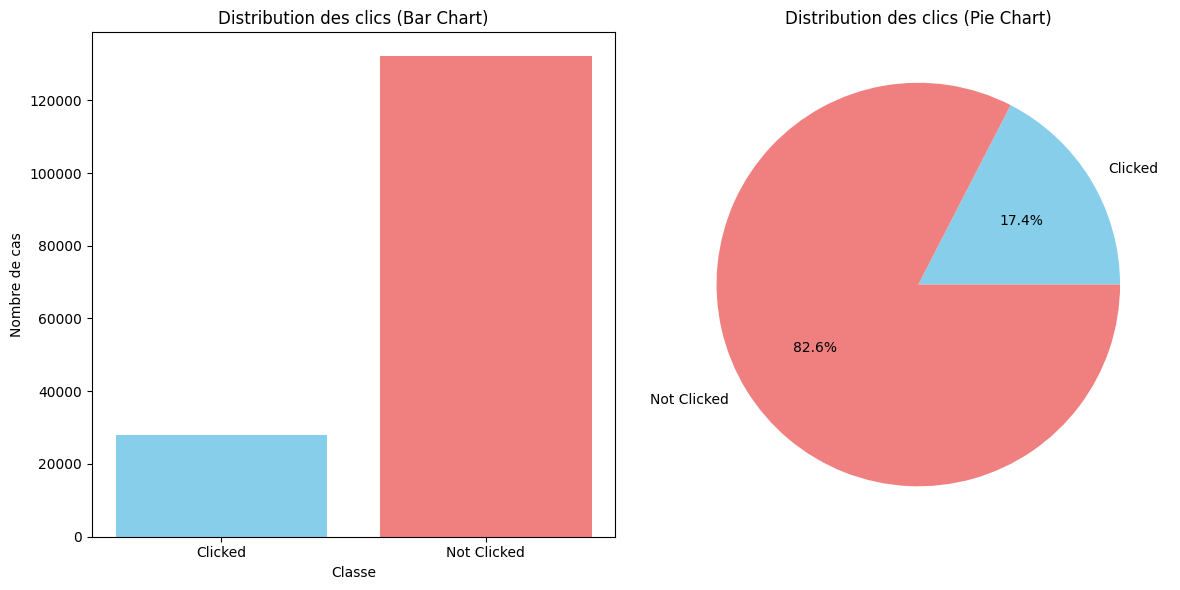

In [25]:
# Ajouter une colonne descriptive
df_click_status = train_data_clean.withColumn(
    "Click_Status",
    when(col("label") == 1, "Clicked").otherwise("Not Clicked")
)

# Compter les occurrences
class_counts = (
    df_click_status.groupBy("Click_Status")
    .count()
    .orderBy("Click_Status")
    .collect()
)

# Transformer en listes Python
labels = [row["Click_Status"] for row in class_counts]
counts = [row["count"] for row in class_counts]

# Création des graphiques
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

# Bar chart
ax[0].bar(labels, counts, color=["skyblue", "lightcoral"])
ax[0].set_title("Distribution des clics (Bar Chart)")
ax[0].set_xlabel("Classe")
ax[0].set_ylabel("Nombre de cas")

# Pie chart
ax[1].pie(counts, labels=labels, autopct="%1.1f%%", colors=["skyblue", "lightcoral"])
ax[1].set_title("Distribution des clics (Pie Chart)")

plt.tight_layout()
plt.show()

In [ ]:
# Compter les classes
count_clicked = df_click_status.filter(col("Click_Status") == "Clicked").count()
count_not_clicked = df_click_status.filter(col("Click_Status") == "Not Clicked").count()

# Calcul du ratio
ratio = count_not_clicked / count_clicked

# Sur-échantillonnage de la classe minoritaire
clicked_oversampled = df_click_status.filter(col("Click_Status") == "Clicked").sample(
    withReplacement=True, fraction=ratio, seed=42
)

# Union des deux classes
balanced_df = clicked_oversampled.unionAll(
    df_click_status.filter(col("Click_Status") == "Not Clicked")
)

print("Dataset équilibré :", balanced_df.count(), "lignes")